In [1]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

In [2]:
def evraz_metric(true_t, predict_t, true_c, predict_c):

    delta_c = np.abs(np.array(true_c) - np.array(predict_c))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(true_t) - np.array(predict_t))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(predict_c)

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [3]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [4]:
path = Path('../../../data/2021_evraz')

In [5]:
target_train = pd.read_pickle(path.joinpath('target_train_wo_gas_wo_sip.pkl'))
print(target_train.shape)
target_train.head(3)

(2063, 145)


,NPLV,TST,C,VES,T,SI,MN,S,P,CR,...,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54,pol_ras_sum
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,0,1,0,0,1,0,0,0,0,593045.405789
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,0,1,0,0,1,0,0,0,0,567680.040137
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0,1,0,0,1,0,0,0,0,591476.261946


In [6]:
test = pd.read_pickle(path.joinpath('test_wo_gas_wo_sip.pkl'))
print(test.shape)
test.head(3)

(780, 143)


,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,...,plavka_TIPE_FUR_koniceskaa,plavka_TIPE_FUR_zilindriceskaa,plavka_TIPE_GOL_4-soplh54,plavka_TIPE_GOL_4-soplx54,plavka_TIPE_GOL_5soplovaa,plavka_TIPE_GOL_601-5,plavka_TIPE_GOL_E32,plavka_TIPE_GOL_E37_4-soplh54,plavka_TIPE_GOL_E_4-soplh54,pol_ras_sum
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0,1,1,0,0,0,0,0,0,463015.154170
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0,1,1,0,0,0,0,0,0,499984.992640
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,1,1,0,0,0,0,0,0,468358.082766


Получается, что по тесту у нас метрика качества 0.561 и 0.431. А когда мы оценили доверительный интервал, у нас получилось  t = (0.428, 0.660) и c = (0.029, 0.641). Это оцень широкий доверительный интервал. Он говорит, что равновероятно у нас метрика может иметь значение внутри этих границ. Т.е. наша валидация неустойчива.

Считается, что если ширина доверительного интервала больше 10%, то это не надёжный доверительный интервал.

In [16]:
def make_cross_validation(X: pd.DataFrame,
                          y_1: pd.Series,
                          y_2: pd.Series,
                          X_test: pd.DataFrame,
                          estimator_1: object,
                          estimator_2: object,
                          metric: callable,
                          cv_strategy,
                          error_to_be_outlier: None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y_1: pd.Series
        Вектор 1-й целевой переменной.
        
    y_2: pd.Series
        Вектор 2-й целевой переменной.
        
    X_test: pd.Series
        Матрица признаков для предсказания.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
        
    error_to_be_outlier: float, optional, default = None
        Максимальная относительная величина ошибки для того,
        чтобы объект считать выбросом и не учитывать в итоговой
        ошибке алгоритма. Опциональный параметр, по умолчанию,
        не используется.
        Если ставим 100, это 100% - если 2 раза ошибаемся, то
        говорим, что это выброс.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, fold_valid_scores_2, \
    evraz_metric_train_scores, evraz_metric_valid_scores = [], [], [], [], [], [], []
    oof_predictions_1, oof_predictions_2 = np.zeros(X.shape[0]), np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y_1)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train_1, y_valid_1 = y_1.loc[train_idx], y_1.loc[valid_idx]
        y_train_2, y_valid_2 = y_2.loc[train_idx], y_2.loc[valid_idx]

        estimator_1.fit(x_train, y_train_1)
        estimator_2.fit(x_train, y_train_2)
        y_train_pred_1 = estimator_1.predict(x_train)
        y_train_pred_2 = estimator_2.predict(x_train)
        y_valid_pred_1 = estimator_1.predict(x_valid)
        y_valid_pred_2 = estimator_2.predict(x_valid)

        fold_train_scores_1.append(metric(y_train_1, y_train_pred_1))
        fold_train_scores_2.append(metric(y_train_2, y_train_pred_2))
        
        if not error_to_be_outlier:
            fold_valid_scores_1.append(metric(y_valid_1, y_valid_pred_1))
            fold_valid_scores_2.append(metric(y_valid_2, y_valid_pred_2))
        else:
            mask = ((y_valid_1 - y_valid_pred_1) / y_valid_1) < error_to_be_outlier
            fold_valid_scores_1.append(metric(y_valid_1.loc[mask], y_valid_pred_1[mask]))
            mask = ((y_valid_2 - y_valid_pred_2) / y_valid_2) < error_to_be_outlier
            fold_valid_scores_2.append(metric(y_valid_2.loc[mask], y_valid_pred_2[mask]))
            
        oof_predictions_1[valid_idx] = y_valid_pred_1
        oof_predictions_2[valid_idx] = y_valid_pred_2
        
        evraz_metric_train = evraz_metric(y_train_1, y_train_pred_1, y_train_2, y_train_pred_2)
        evraz_metric_valid = evraz_metric(y_valid_1, y_valid_pred_1, y_valid_2, y_valid_pred_2)
        evraz_metric_train_scores.append(evraz_metric_train)
        evraz_metric_valid_scores.append(evraz_metric_valid)

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score 1 = {round(fold_train_scores_1[fold_number], 4)}, "
            f"train-score 2 = {round(fold_train_scores_2[fold_number], 4)}\n"
            f"valid-score 1 = {round(fold_valid_scores_1[fold_number], 4)}, "
            f"valid-score 2 = {round(fold_valid_scores_2[fold_number], 4)}" 
        )
        print(msg)
        print('Train metric = ', round(evraz_metric_train, 4))
        print('Valid metric = ', round(evraz_metric_valid, 4))
        print("="*69)
        estimators.append(estimator_1)
        estimators.append(estimator_2)

    if not error_to_be_outlier:
        oof_score_1 = metric(y_1, oof_predictions_1)
        oof_score_2 = metric(y_2, oof_predictions_2)
    else:
        mask = ((y_1 - oof_predictions_1) / y_1) < error_to_be_outlier
        oof_score_1 = metric(y_1.loc[mask], oof_predictions_1[mask])
        mask = ((y_2 - oof_predictions_2) / y_1) < error_to_be_outlier
        oof_score_2 = metric(y_2.loc[mask], oof_predictions_2[mask])
        
    print(f"CV-results train 1: {round(np.mean(fold_train_scores_1), 4)} +/- {round(np.std(fold_train_scores_1), 3)}")
    print(f"CV-results train 2: {round(np.mean(fold_train_scores_2), 4)} +/- {round(np.std(fold_train_scores_2), 3)}")
    print(f"CV-results valid 1: {round(np.mean(fold_valid_scores_1), 4)} +/- {round(np.std(fold_valid_scores_1), 3)}")
    print(f"CV-results valid 2: {round(np.mean(fold_valid_scores_2), 4)} +/- {round(np.std(fold_valid_scores_2), 3)}")
    print(f"OOF-score 1 = {round(oof_score_1, 4)}")
    print(f"OOF-score 2 = {round(oof_score_2, 4)}")
    
    print(f"CV-results evraz metric train: {round(np.mean(evraz_metric_train_scores), 4)}\
+/- {round(np.std(evraz_metric_train_scores), 3)}")
    print(f"CV-results evraz metric valid: {round(np.mean(evraz_metric_valid_scores), 4)}\
+/- {round(np.std(evraz_metric_valid_scores), 3)}")
    
    # error fix: ValueError: Feature shape mismatch, expected: 142, got 780
    # https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function
    f_names = estimator_1.get_booster().feature_names 
    X_test = X_test[f_names]
    
    return estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1,\
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, estimator_1.predict(X_test), estimator_2.predict(X_test),\
np.mean(evraz_metric_train_scores), np.mean(evraz_metric_valid_scores)

  0%|                                                                                           | 0/16 [00:00<?, ?it/s]

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8844, train-score 2 = 0.9736
valid-score 1 = 0.4121, valid-score 2 = 0.4213
Train metric =  0.8903
Valid metric =  0.6259
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8749, train-score 2 = 0.9767
valid-score 1 = 0.4574, valid-score 2 = 0.4795
Train metric =  0.8958
Valid metric =  0.6961
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.873, train-score 2 = 0.9821
valid-score 1 = 0.5191, valid-score 2 = 0.6267
Train metric =  0.9152
Valid metric =  0.6005
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8614, train-score 2 = 0.9781
valid-score 1 = 0.5847, valid-score 2 = 0.4779
Train metric =  0.8922
Valid metric =  0.6553


  6%|█████▏                                                                             | 1/16 [00:01<00:23,  1.57s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8799, train-score 2 = 0.9734
valid-score 1 = 0.3885, valid-score 2 = 0.7266
Train metric =  0.8864
Valid metric =  0.6323
CV-results train 1: 0.8747 +/- 0.008
CV-results train 2: 0.9768 +/- 0.003
CV-results valid 1: 0.4724 +/- 0.072
CV-results valid 2: 0.5464 +/- 0.113
OOF-score 1 = 0.4844
OOF-score 2 = 0.559
CV-results evraz metric train: 0.896+/- 0.01
CV-results evraz metric valid: 0.642+/- 0.032
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8762, train-score 2 = 0.9728
valid-score 1 = 0.4187, valid-score 2 = 0.4217
Train metric =  0.8858
Valid metric =  0.6295
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8706, train-score 2 = 0.976
valid-score 1 = 0.4609, valid-score 2 = 0.4783
Train metric =  0.8906
Valid metric =  0.6973
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8674, train-score 2 = 0.9803
valid-scor

 12%|██████████▍                                                                        | 2/16 [00:03<00:22,  1.59s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8704, train-score 2 = 0.9718
valid-score 1 = 0.3962, valid-score 2 = 0.7259
Train metric =  0.878
Valid metric =  0.6311
CV-results train 1: 0.868 +/- 0.007
CV-results train 2: 0.9757 +/- 0.003
CV-results valid 1: 0.4768 +/- 0.07
CV-results valid 2: 0.5465 +/- 0.113
OOF-score 1 = 0.4886
OOF-score 2 = 0.559
CV-results evraz metric train: 0.8897+/- 0.009
CV-results evraz metric valid: 0.6415+/- 0.033
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8696, train-score 2 = 0.9717
valid-score 1 = 0.4197, valid-score 2 = 0.4168
Train metric =  0.8782
Valid metric =  0.6332
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8664, train-score 2 = 0.9749
valid-score 1 = 0.4576, valid-score 2 = 0.4776
Train metric =  0.8858
Valid metric =  0.6949
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8604, train-score 2 = 0.9796
valid-sco

 19%|███████████████▌                                                                   | 3/16 [00:04<00:20,  1.56s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8662, train-score 2 = 0.9701
valid-score 1 = 0.4027, valid-score 2 = 0.7257
Train metric =  0.8743
Valid metric =  0.6347
CV-results train 1: 0.861 +/- 0.01
CV-results train 2: 0.9746 +/- 0.003
CV-results valid 1: 0.4757 +/- 0.066
CV-results valid 2: 0.545 +/- 0.114
OOF-score 1 = 0.4868
OOF-score 2 = 0.5577
CV-results evraz metric train: 0.8829+/- 0.008
CV-results evraz metric valid: 0.6415+/- 0.032
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8656, train-score 2 = 0.9705
valid-score 1 = 0.416, valid-score 2 = 0.417
Train metric =  0.8736
Valid metric =  0.6308
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8617, train-score 2 = 0.9746
valid-score 1 = 0.459, valid-score 2 = 0.4774
Train metric =  0.8836
Valid metric =  0.6937
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8491, train-score 2 = 0.979
valid-score 

 25%|████████████████████▊                                                              | 4/16 [00:06<00:18,  1.52s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8521, train-score 2 = 0.969
valid-score 1 = 0.4002, valid-score 2 = 0.7258
Train metric =  0.8622
Valid metric =  0.6359
CV-results train 1: 0.8535 +/- 0.009
CV-results train 2: 0.9736 +/- 0.004
CV-results valid 1: 0.4748 +/- 0.068
CV-results valid 2: 0.545 +/- 0.114
OOF-score 1 = 0.4862
OOF-score 2 = 0.5577
CV-results evraz metric train: 0.8772+/- 0.01
CV-results evraz metric valid: 0.6428+/- 0.031
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8575, train-score 2 = 0.9685
valid-score 1 = 0.4107, valid-score 2 = 0.4193
Train metric =  0.8655
Valid metric =  0.6223
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8569, train-score 2 = 0.9728
valid-score 1 = 0.4566, valid-score 2 = 0.4784
Train metric =  0.8764
Valid metric =  0.6949
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8458, train-score 2 = 0.9771
valid-sc

 31%|█████████████████████████▉                                                         | 5/16 [00:07<00:16,  1.53s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8444, train-score 2 = 0.9678
valid-score 1 = 0.4331, valid-score 2 = 0.7263
Train metric =  0.8546
Valid metric =  0.6408
CV-results train 1: 0.8461 +/- 0.012
CV-results train 2: 0.9721 +/- 0.004
CV-results valid 1: 0.4793 +/- 0.063
CV-results valid 2: 0.5456 +/- 0.114
OOF-score 1 = 0.4886
OOF-score 2 = 0.5583
CV-results evraz metric train: 0.8697+/- 0.01
CV-results evraz metric valid: 0.6411+/- 0.032
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8478, train-score 2 = 0.967
valid-score 1 = 0.4154, valid-score 2 = 0.4223
Train metric =  0.8585
Valid metric =  0.6259
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8464, train-score 2 = 0.9714
valid-score 1 = 0.4528, valid-score 2 = 0.4766
Train metric =  0.8648
Valid metric =  0.6925
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8357, train-score 2 = 0.976
valid-sc

 38%|███████████████████████████████▏                                                   | 6/16 [00:09<00:14,  1.48s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8332, train-score 2 = 0.9661
valid-score 1 = 0.4369, valid-score 2 = 0.726
Train metric =  0.8428
Valid metric =  0.6311
CV-results train 1: 0.8357 +/- 0.012
CV-results train 2: 0.9707 +/- 0.004
CV-results valid 1: 0.4802 +/- 0.062
CV-results valid 2: 0.5454 +/- 0.113
OOF-score 1 = 0.4894
OOF-score 2 = 0.5579
CV-results evraz metric train: 0.8604+/- 0.012
CV-results evraz metric valid: 0.6401+/- 0.031
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8306, train-score 2 = 0.9661
valid-score 1 = 0.4069, valid-score 2 = 0.42
Train metric =  0.8442
Valid metric =  0.6283
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8322, train-score 2 = 0.9695
valid-score 1 = 0.4556, valid-score 2 = 0.4758
Train metric =  0.853
Valid metric =  0.7034
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8222, train-score 2 = 0.9746
valid-sco

 44%|████████████████████████████████████▎                                              | 7/16 [00:10<00:12,  1.42s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8251, train-score 2 = 0.9624
valid-score 1 = 0.4634, valid-score 2 = 0.7248
Train metric =  0.8313
Valid metric =  0.6493
CV-results train 1: 0.8224 +/- 0.011
CV-results train 2: 0.9687 +/- 0.004
CV-results valid 1: 0.4828 +/- 0.06
CV-results valid 2: 0.5447 +/- 0.113
OOF-score 1 = 0.4902
OOF-score 2 = 0.5572
CV-results evraz metric train: 0.8488+/- 0.013
CV-results evraz metric valid: 0.6471+/- 0.032
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8131, train-score 2 = 0.9643
valid-score 1 = 0.3931, valid-score 2 = 0.4214
Train metric =  0.8339
Valid metric =  0.6102
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8161, train-score 2 = 0.9684
valid-score 1 = 0.4526, valid-score 2 = 0.4743
Train metric =  0.8445
Valid metric =  0.7058
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8078, train-score 2 = 0.9729
valid-

 50%|█████████████████████████████████████████▌                                         | 8/16 [00:11<00:10,  1.35s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8134, train-score 2 = 0.9603
valid-score 1 = 0.506, valid-score 2 = 0.7262
Train metric =  0.8234
Valid metric =  0.6602
CV-results train 1: 0.8068 +/- 0.012
CV-results train 2: 0.9672 +/- 0.004
CV-results valid 1: 0.4841 +/- 0.063
CV-results valid 2: 0.5449 +/- 0.113
OOF-score 1 = 0.4884
OOF-score 2 = 0.5573
CV-results evraz metric train: 0.8408+/- 0.014
CV-results evraz metric valid: 0.6469+/- 0.037
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7892, train-score 2 = 0.961
valid-score 1 = 0.3835, valid-score 2 = 0.4202
Train metric =  0.8158
Valid metric =  0.6114
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7865, train-score 2 = 0.9663
valid-score 1 = 0.4509, valid-score 2 = 0.4721
Train metric =  0.8215
Valid metric =  0.7022
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7854, train-score 2 = 0.9721
valid-s

 56%|██████████████████████████████████████████████▋                                    | 9/16 [00:12<00:09,  1.30s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7902, train-score 2 = 0.9573
valid-score 1 = 0.5006, valid-score 2 = 0.7255
Train metric =  0.811
Valid metric =  0.6602
CV-results train 1: 0.7826 +/- 0.011
CV-results train 2: 0.9648 +/- 0.005
CV-results valid 1: 0.476 +/- 0.064
CV-results valid 2: 0.5449 +/- 0.114
OOF-score 1 = 0.4802
OOF-score 2 = 0.5573
CV-results evraz metric train: 0.8241+/- 0.015
CV-results evraz metric valid: 0.6479+/- 0.035
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7599, train-score 2 = 0.9589
valid-score 1 = 0.3589, valid-score 2 = 0.4213
Train metric =  0.7994
Valid metric =  0.6053
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7603, train-score 2 = 0.9635
valid-score 1 = 0.4284, valid-score 2 = 0.469
Train metric =  0.8033
Valid metric =  0.6998
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7511, train-score 2 = 0.969
valid-sco

 62%|███████████████████████████████████████████████████▎                              | 10/16 [00:14<00:07,  1.30s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7533, train-score 2 = 0.9517
valid-score 1 = 0.4907, valid-score 2 = 0.7256
Train metric =  0.7862
Valid metric =  0.6699
CV-results train 1: 0.7508 +/- 0.011
CV-results train 2: 0.9612 +/- 0.006
CV-results valid 1: 0.4552 +/- 0.07
CV-results valid 2: 0.5442 +/- 0.114
OOF-score 1 = 0.4589
OOF-score 2 = 0.5564
CV-results evraz metric train: 0.803+/- 0.013
CV-results evraz metric valid: 0.6442+/- 0.04
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.696, train-score 2 = 0.9535
valid-score 1 = 0.3102, valid-score 2 = 0.4162
Train metric =  0.7615
Valid metric =  0.5981
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7048, train-score 2 = 0.9606
valid-score 1 = 0.3948, valid-score 2 = 0.4653
Train metric =  0.7748
Valid metric =  0.6852
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6922, train-score 2 = 0.9658
valid-sco

 69%|████████████████████████████████████████████████████████▍                         | 11/16 [00:15<00:06,  1.25s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.6889, train-score 2 = 0.9481
valid-score 1 = 0.4677, valid-score 2 = 0.728
Train metric =  0.758
Valid metric =  0.6566
CV-results train 1: 0.69 +/- 0.012
CV-results train 2: 0.9578 +/- 0.006
CV-results valid 1: 0.4184 +/- 0.078
CV-results valid 2: 0.5426 +/- 0.117
OOF-score 1 = 0.4213
OOF-score 2 = 0.5551
CV-results evraz metric train: 0.7724+/- 0.013
CV-results evraz metric valid: 0.6321+/- 0.039
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6004, train-score 2 = 0.949
valid-score 1 = 0.2028, valid-score 2 = 0.4178
Train metric =  0.7155
Valid metric =  0.5666
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6079, train-score 2 = 0.9551
valid-score 1 = 0.3267, valid-score 2 = 0.4564
Train metric =  0.7309
Valid metric =  0.6501
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.5957, train-score 2 = 0.9603
valid-scor

 75%|█████████████████████████████████████████████████████████████▌                    | 12/16 [00:16<00:04,  1.18s/it]

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4307, train-score 2 = 0.9446
valid-score 1 = 0.0092, valid-score 2 = 0.415
Train metric =  0.6458
Valid metric =  0.5097
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4423, train-score 2 = 0.9519
valid-score 1 = 0.1836, valid-score 2 = 0.4677
Train metric =  0.6627
Valid metric =  0.6017
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4231, train-score 2 = 0.9556
valid-score 1 = 0.0982, valid-score 2 = 0.6253
Train metric =  0.6785
Valid metric =  0.5169
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.4019, train-score 2 = 0.9532
valid-score 1 = 0.3625, valid-score 2 = 0.4674
Train metric =  0.6693
Valid metric =  0.5825


 81%|██████████████████████████████████████████████████████████████████▋               | 13/16 [00:17<00:03,  1.11s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.4369, train-score 2 = 0.9391
valid-score 1 = 0.2497, valid-score 2 = 0.7256
Train metric =  0.6523
Valid metric =  0.591
CV-results train 1: 0.427 +/- 0.014
CV-results train 2: 0.9489 +/- 0.006
CV-results valid 1: 0.1806 +/- 0.122
CV-results valid 2: 0.5402 +/- 0.116
OOF-score 1 = 0.1841
OOF-score 2 = 0.553
CV-results evraz metric train: 0.6617+/- 0.012
CV-results evraz metric valid: 0.5604+/- 0.039
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1022, train-score 2 = 0.9414
valid-score 1 = -0.3724, valid-score 2 = 0.4033
Train metric =  0.5452
Valid metric =  0.3995
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1192, train-score 2 = 0.9461
valid-score 1 = -0.1276, valid-score 2 = 0.4525
Train metric =  0.5573
Valid metric =  0.4939
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.0966, train-score 2 = 0.9475
valid-

 88%|███████████████████████████████████████████████████████████████████████▊          | 14/16 [00:18<00:02,  1.03s/it]

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -0.5338, train-score 2 = 0.9332
valid-score 1 = -1.0265, valid-score 2 = 0.3891
Train metric =  0.3994
Valid metric =  0.2954
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -0.504, train-score 2 = 0.9354
valid-score 1 = -0.7504, valid-score 2 = 0.4391
Train metric =  0.4109
Valid metric =  0.3511
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -0.5384, train-score 2 = 0.9373
valid-score 1 = -0.9198, valid-score 2 = 0.6233
Train metric =  0.407
Valid metric =  0.3341
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -0.5982, train-score 2 = 0.9412
valid-score 1 = -0.3177, valid-score 2 = 0.4603
Train metric =  0.4128
Valid metric =  0.3811


 94%|████████████████████████████████████████████████████████████████████████████▉     | 15/16 [00:18<00:00,  1.04it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -0.4437, train-score 2 = 0.9225
valid-score 1 = -0.8589, valid-score 2 = 0.7165
Train metric =  0.4004
Valid metric =  0.3859
CV-results train 1: -0.5236 +/- 0.05
CV-results train 2: 0.9339 +/- 0.006
CV-results valid 1: -0.7747 +/- 0.245
CV-results valid 2: 0.5257 +/- 0.124
OOF-score 1 = -0.7487
OOF-score 2 = 0.5386
CV-results evraz metric train: 0.4061+/- 0.005
CV-results evraz metric valid: 0.3495+/- 0.033
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7942, train-score 2 = 0.9187
valid-score 1 = -2.2762, valid-score 2 = 0.3777
Train metric =  0.2527
Valid metric =  0.2155
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7193, train-score 2 = 0.9173
valid-score 1 = -1.9927, valid-score 2 = 0.4164
Train metric =  0.2697
Valid metric =  0.1937
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7993, train-score 2 = 0.9

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.23s/it]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -1.9073, train-score 2 = 0.9281
valid-score 1 = -1.2598, valid-score 2 = 0.4535
Train metric =  0.2735
Valid metric =  0.2694
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -1.598, train-score 2 = 0.9057
valid-score 1 = -2.4778, valid-score 2 = 0.7022
Train metric =  0.2562
Valid metric =  0.2379
CV-results train 1: -1.7636 +/- 0.102
CV-results train 2: 0.9185 +/- 0.007
CV-results valid 1: -2.023 +/- 0.415
CV-results valid 2: 0.5145 +/- 0.126
OOF-score 1 = -1.956
OOF-score 2 = 0.527
CV-results evraz metric train: 0.2633+/- 0.008
CV-results evraz metric valid: 0.2286+/- 0.025


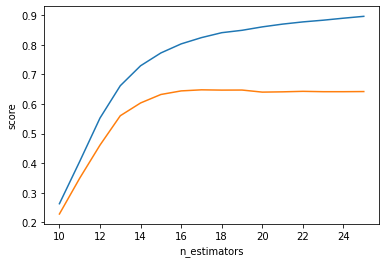

In [28]:
cv_strategy = KFold(n_splits=5)

n_trees, current_score_train, current_score_valid  = [], [], []

for i in tqdm(range(25, 9, -1)):
    estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
    fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
    evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
        target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
        target_train['TST'], 
        target_train['C'],
        test.drop(['DATA_ZAMERA'], axis=1),
        estimator_1=xgb.XGBRegressor(n_estimators=i, random_state=1), 
        estimator_2=xgb.XGBRegressor(n_estimators=i, random_state=1),
        metric=r2_score, 
        cv_strategy=cv_strategy,
        error_to_be_outlier=None,
    )
    
    current_score_train.append(evraz_metric_train_scores_mean)
    current_score_valid.append(evraz_metric_valid_scores_mean)
    n_trees.append(i)

plt.plot(n_trees, current_score_train)
plt.plot(n_trees, current_score_valid)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

In [30]:
cv_strategy = KFold(n_splits=5)
#cv_strategy = StratifiedKFold(n_splits=5)

n_trees=15

estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
    target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
    target_train['TST'], 
    target_train['C'],
    test.drop(['DATA_ZAMERA'], axis=1),
    estimator_1=xgb.XGBRegressor(n_estimators=n_trees, random_state=1), 
    estimator_2=xgb.XGBRegressor(n_estimators=n_trees, random_state=1),
    metric=r2_score, 
    cv_strategy=cv_strategy,
    error_to_be_outlier=None,
)

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.696, train-score 2 = 0.9535
valid-score 1 = 0.3102, valid-score 2 = 0.4162
Train metric =  0.7615
Valid metric =  0.5981
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7048, train-score 2 = 0.9606
valid-score 1 = 0.3948, valid-score 2 = 0.4653
Train metric =  0.7748
Valid metric =  0.6852
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6922, train-score 2 = 0.9658
valid-score 1 = 0.3817, valid-score 2 = 0.6292
Train metric =  0.7945
Valid metric =  0.5775
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.6681, train-score 2 = 0.9612
valid-score 1 = 0.5375, valid-score 2 = 0.4742
Train metric =  0.7729
Valid metric =  0.6432
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.6889, train-score 2 = 0.9481
valid-score 1 = 0.4677, valid-score 2 = 0.728
Train metric =  0.758
Valid metric =  0.656

In [31]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_pred_1).rename('TST'), 
                    pd.Series(test_pred_2).rename('C')
                   ],
                   axis=1
                  )
print(submit.shape)
submit.head(5)

(780, 3)


,NPLV,TST,C
0,512324,1646.549194,0.046477
1,512327,1652.305908,0.049586
2,512328,1643.454590,0.053136
3,512331,1644.583496,0.045794
4,512333,1652.073975,0.049717


In [32]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'xgb_n-tree-15_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  xgb_n-tree-15_2021-10-31_05-56-19.csv

 File saved to disk!
